BASELINE ACCURACY: 0.7055

Logistic Regression Results:
Accuracy: 0.9931506849315068
Precision: 1.0
Recall: 0.9902912621359223
AUC: 1.0

Random Forest Results:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
AUC: 1.0


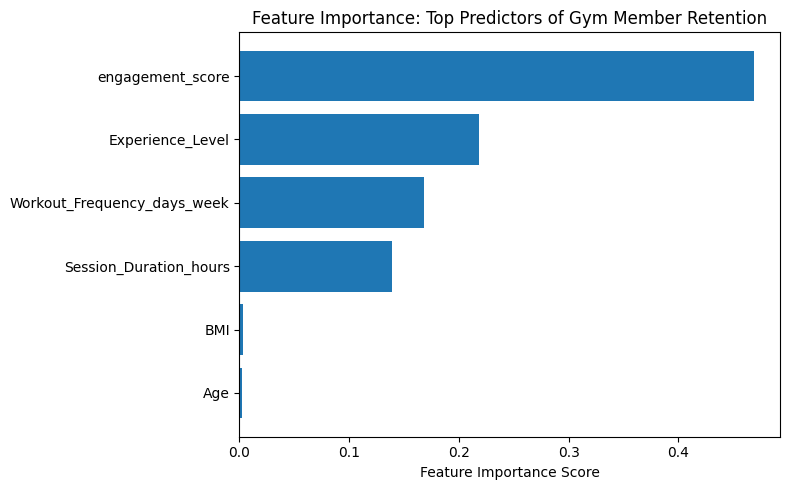

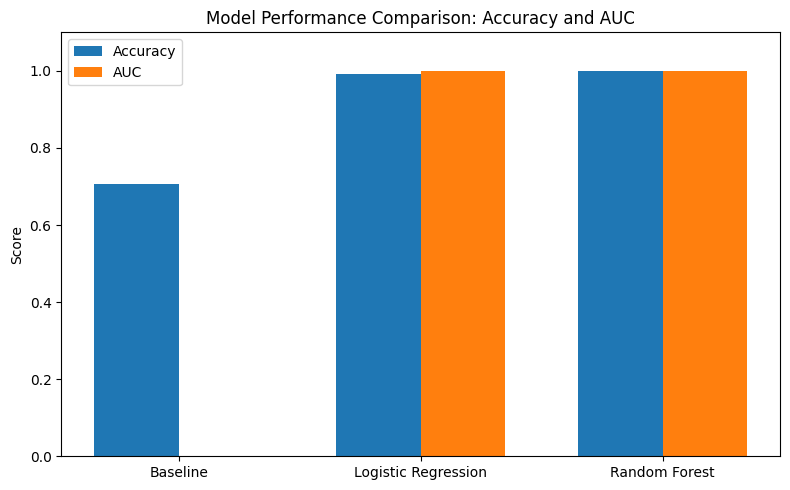

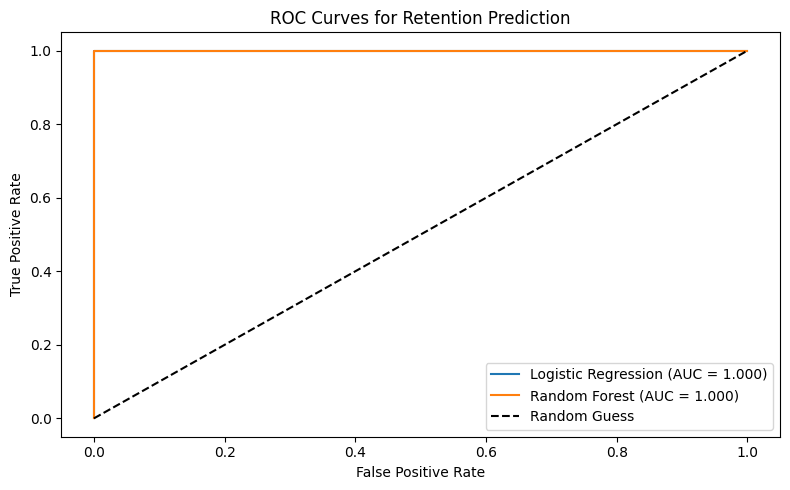

<Figure size 600x500 with 0 Axes>

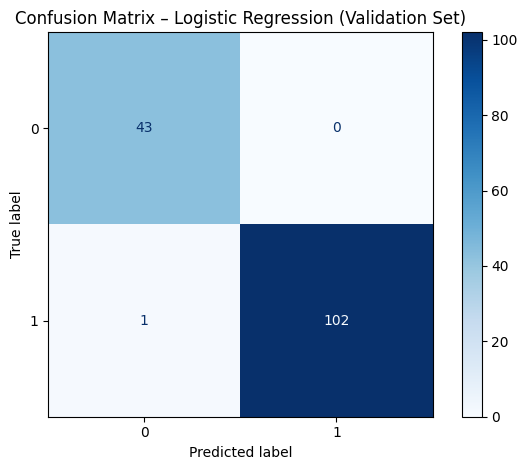

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# -----------------------------
# 0. Paths & Data Loading
# -----------------------------

FIG_DIR = "../reports/figures"   # if notebook is in notebooks/
Path(FIG_DIR).mkdir(parents=True, exist_ok=True)

df = pd.read_csv("../data/processed/gym_members_cleaned.csv")

# Ensure engagement_score and retention_status exist
if "engagement_score" not in df.columns:
    df["engagement_score"] = df["Workout_Frequency_days_week"] * df["Session_Duration_hours"]

if "retention_status" not in df.columns:
    threshold = df["engagement_score"].quantile(0.60)
    df["retention_status"] = (df["engagement_score"] >= threshold).astype(int)

# -----------------------------
# 1. Train / Validation / Test Split
# -----------------------------

feature_cols = [
    "Workout_Frequency_days_week",
    "Session_Duration_hours",
    "Experience_Level",
    "Age",
    "BMI",
    "engagement_score",
]

X = df[feature_cols]
y = df["retention_status"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# Scale for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 2. Baseline, Logistic Regression, Random Forest
# -----------------------------

# Baseline – always predict majority class in training set
majority_class = y_train.mode()[0]
y_val_baseline = np.full_like(y_val, fill_value=majority_class)
baseline_acc = accuracy_score(y_val, y_val_baseline)

print("BASELINE ACCURACY:", round(baseline_acc, 4))

# Logistic Regression
log_reg = LogisticRegression(class_weight="balanced", max_iter=2000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_val_log = log_reg.predict(X_val_scaled)
y_val_log_proba = log_reg.predict_proba(X_val_scaled)[:, 1]

log_acc = accuracy_score(y_val, y_val_log)
log_prec = precision_score(y_val, y_val_log)
log_rec = recall_score(y_val, y_val_log)
log_auc = roc_auc_score(y_val, y_val_log_proba)

print("\nLogistic Regression Results:")
print("Accuracy:", log_acc)
print("Precision:", log_prec)
print("Recall:", log_rec)
print("AUC:", log_auc)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train, y_train)
y_val_rf = rf.predict(X_val)
y_val_rf_proba = rf.predict_proba(X_val)[:, 1]

rf_acc = accuracy_score(y_val, y_val_rf)
rf_prec = precision_score(y_val, y_val_rf)
rf_rec = recall_score(y_val, y_val_rf)
rf_auc = roc_auc_score(y_val, y_val_rf_proba)

print("\nRandom Forest Results:")
print("Accuracy:", rf_acc)
print("Precision:", rf_prec)
print("Recall:", rf_rec)
print("AUC:", rf_auc)

# -----------------------------
# 3. Feature Importance (Random Forest)
# -----------------------------

importances = rf.feature_importances_
sorted_idx = np.argsort(importances)
sorted_features = np.array(feature_cols)[sorted_idx]

plt.figure(figsize=(8, 5))
plt.barh(sorted_features, importances[sorted_idx])
plt.xlabel("Feature Importance Score")
plt.title("Feature Importance: Top Predictors of Gym Member Retention")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "feature_importance.png"), dpi=300, bbox_inches="tight")
plt.show()

# -----------------------------
# 4. Model Performance Comparison
# -----------------------------

models = ["Baseline", "Logistic Regression", "Random Forest"]
accuracy_scores = [baseline_acc, log_acc, rf_acc]
auc_scores = [np.nan, log_auc, rf_auc]  # baseline has no AUC

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, accuracy_scores, width, label="Accuracy")
plt.bar(x + width/2, auc_scores, width, label="AUC")

plt.xticks(x, models)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("Model Performance Comparison: Accuracy and AUC")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "model_performance_comparison.png"), dpi=300, bbox_inches="tight")
plt.show()

# -----------------------------
# 5. ROC Curves
# -----------------------------

fpr_log, tpr_log, _ = roc_curve(y_val, y_val_log_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_val_rf_proba)

plt.figure(figsize=(8, 5))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {log_auc:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Retention Prediction")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "roc_curves.png"), dpi=300, bbox_inches="tight")
plt.show()

# -----------------------------
# 6. Confusion Matrix – Logistic Regression
# -----------------------------

cm_log = confusion_matrix(y_val, y_val_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=[0, 1])

plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Logistic Regression (Validation Set)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "confusion_matrix_logreg.png"), dpi=300, bbox_inches="tight")
plt.show()
